# Universal Constants

In [ ]:
# Bu değerleri değiştirince training data'nın resolution'ı da değişmeli pre-processingde (Haar2D).
# Training data için width ve height bu değerlerin tam ikişer katı olmalı. (500x375 => 1000x750; 1000x750 => 2000x1500 gibi)
WIDTH=500
HEIGHT=375

# UNZİP


In [ ]:
!unzip '/content/drive/MyDrive/fraudfull/brighttancrop/accept_crop_bright_12.zip' -d '/content/unzip_accept_12'
!unzip '/content/drive/MyDrive/fraudfull/brighttancrop/discard_crop_bright_12.zip' -d '/content/unzip_discard_12'

Streaming output truncated to the last 5000 lines.
  inflating: /content/unzip_accept_12/accept_crop_bright_12/upper_leftoriented_20210612t033245_a007d17c_f3e7_478a_8130_7aeaa98e650c_180_HH.tiff  
  inflating: /content/unzip_accept_12/accept_crop_bright_12/bottom_leftoriented_20220111t131148_98d4c725_1906_41de_8d05_713698e698e3_180_LL.tiff  
  inflating: /content/unzip_accept_12/accept_crop_bright_12/upper_rightoriented_20220814t084854_6e18c7c5_2b57_4311_b44b_54698e6963ca_HH.tiff  
  inflating: /content/unzip_accept_12/accept_crop_bright_12/upper_rightoriented_20220215t054903_82220767_2497_48fd_98e6_0cb6699a19ff_180_FLIP_HL.tiff  
  inflating: /content/unzip_accept_12/accept_crop_bright_12/upper_leftoriented_20210727t105612_431520f3_d12c_4586_9270_ec098e61b9ad_180_LL.tiff  
  inflating: /content/unzip_accept_12/accept_crop_bright_12/bottom_rightoriented_20211105t014621_831afd05_9176_4ade_8384_82fa4ec298e6_HL.tiff  
  inflating: /content/unzip_accept_12/accept_crop_bright_12/upper_right

#Definitions and Imports
## (For Training and Testing)


## Library Imports

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import sys
import argparse
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn import preprocessing
from skimage import io
import joblib
import random
from sklearn.model_selection import train_test_split
import os
import pandas as pd
#from mCNN import createModel
from keras.utils import np_utils  # utilities for one-hot encoding of ground truth values
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

## Create Model

In [ ]:
# The convolutional layer C1 filter three 512 x 384 input images with 32 kernels of size 7 x 7 with a stride of 1 pixel. The stride of pooling layer S1 is 2 pixels. Then, the convolved images of LH and HL are merged together by taking the maximum from both the images. In the next step, the convolved image of LL is merged with the Max result by multiplying both the results (as explained in section III-B). C2-C4 has 16 kernels of size 3 x 3 with a stride of 1 pixel. S2 pools the merged features with a stride of 4. The dropout is applied to the output of S4 which has been flattened. The fully connected layer FC1 has 32 neurons and FC2 has 1 neuron. The activation of the output layer is a softmax function.

# One significant observation found while analyzing the images is, when the image intensities are relatively darker, the patterns aren’t visible much. The darker regions in the image produce less Moire ́ patterns compared to the brighter regions in the image. To summarize the spread of the Moire ́ pattern in the image, spatially, and to produce this effect while training the network, we used the LL band of the image (which is the downsampled original image consisting of low frequency information) and used it as weights for LH anf HL band during the training, by directly multiplying it to the convolved and combined response of the LH and HL bands

import os

from keras.models import Model  # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Add, Multiply, Maximum


def createModel(height, width, depth, num_classes):
    #     num_epochs = 20 # 50 26 200 # we iterate 200 times over the entire training set
    kernel_size_1 = 7  # we will use 7x7 kernels
    kernel_size_2 = 3  # we will use 3x3 kernels
    pool_size = 2  # we will use 2x2 pooling throughout
    conv_depth_1 = 32  # we will initially have 32 kernels per conv. layer...
    conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
    drop_prob_1 = 0.25  # dropout after pooling with probability 0.25
    drop_prob_2 = 0.5  # dropout in the FC layer with probability 0.5
    hidden_size = 32  # 128 512 the FC layer will have 512 neurons

    inpLL = Input(shape=(height, width, depth), name='input_LL')  # depth goes last in TensorFlow back-end (first in Theano)
    inpLH = Input(shape=(height, width, depth), name='input_LH')  # depth goes last in TensorFlow back-end (first in Theano)
    inpHL = Input(shape=(height, width, depth), name='input_HL')  # depth goes last in TensorFlow back-end (first in Theano)
    inpHH = Input(shape=(height, width, depth), name='input_HH')  # depth goes last in TensorFlow back-end (first in Theano)

    conv_1_LL = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpLL)
    conv_1_LH = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpLH)
    conv_1_HL = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpHL)
    conv_1_HH = Convolution2D(conv_depth_1, (kernel_size_1, kernel_size_1), padding='same', activation='relu')(inpHH)
    pool_1_LL = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_LL)
    pool_1_LH = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_LH)
    pool_1_HL = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_HL)
    pool_1_HH = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1_HH)

    avg_LH_HL_HH = Maximum()([pool_1_LH, pool_1_HL, pool_1_HH])
    inp_merged = Multiply()([pool_1_LL, avg_LH_HL_HH])
    C4 = Convolution2D(conv_depth_2, (kernel_size_2, kernel_size_2), padding='same', activation='relu')(inp_merged)
    S2 = MaxPooling2D(pool_size=(4, 4))(C4)
    drop_1 = Dropout(drop_prob_1)(S2)
    C5 = Convolution2D(conv_depth_1, (kernel_size_2, kernel_size_2), padding='same', activation='relu')(drop_1)
    S3 = MaxPooling2D(pool_size=(pool_size, pool_size))(C5)
    C6 = Convolution2D(conv_depth_1, (kernel_size_2, kernel_size_2), padding='same', activation='relu')(S3)
    S4 = MaxPooling2D(pool_size=(pool_size, pool_size))(C6)
    drop_2 = Dropout(drop_prob_1)(S4)
    # Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
    flat = Flatten()(drop_2)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop_3 = Dropout(drop_prob_2)(hidden)
    out = Dense(num_classes, activation='softmax')(drop_3)

    model = Model(inputs=[inpLL , inpLH, inpHL, inpHH],
                  outputs=out) # To define a model, just specify its input and output layers

    return model


## Utility Functions
### String Operations, Feature Scaling, Google Drive Operations

In [ ]:


def scaleData(inp, minimum, maximum):
    minMaxScaler = preprocessing.MinMaxScaler(copy=True, feature_range=(minimum, maximum))
    inp = inp.reshape(-1, 1)
    inp = minMaxScaler.fit_transform(inp)

    return inp


# - read positive and negative training data
# - create X and Y from training data
def remove_all_exts(inp):
    """
    ".jpg" Uzantısını kaldırmak için kullanıyorum.
    Mesela  'oriented_20220122t055407_4799f9ba_457e_46ce_98e6_75693ef54a46.jpg' ->
    'oriented_20220122t055407_4799f9ba_457e_46ce_98e6_75693ef54a46' oluyor
    """
    f = inp.find("_LL.tiff")
    if f != -1:
        return inp[:f]
    f = inp.find("_HL.tiff")
    if f != -1:
        return inp[:f]
    f = inp.find("_LH.tiff")
    if f != -1:
        return inp[:f]
    f = inp.find("_HH.tiff")
    if f != -1:
        return inp[:f]


def remove_extension(inp):
    """
    ".jpg" Uzantısını kaldırmak için kullanıyorum.
    Mesela  'oriented_20220122t055407_4799f9ba_457e_46ce_98e6_75693ef54a46.jpg' ->
    'oriented_20220122t055407_4799f9ba_457e_46ce_98e6_75693ef54a46' oluyor
    """
    return inp[:-4]

def add_extension(inp,ext):
    """
    ".jpg'yi kaldırdıktan sonra '_180' ve '_180_FLIP' eklemek için bunu çağırıyorum.
    Verilen stringin ucunua uzantıyı ekliyor."
    """
    return str(inp)+str(ext)


def copyPathIfDrive(path):
    import shutil
    path_name = path[path.rfind("/")+1:]
    src = "/content/"+path_name
    if os.path.exists(src):
        print(f"Returned {src} for {path}")
        return src
    if path.find("drive") != -1:
        print(f"Copying to {src} from {path}...")
        shutil.copytree(path, src)
        print(f"Returned {src} for {path}")
        return src
    print(f"Path {path} is not drive, won't do nothing!")
    return path


## Training Related Functions (Load, Read, Split)

In [ ]:


def calculate_the_train_test_split_indices_my(X_index,Y,testCountPercent,random_seed=1):


    X_train_ind, X_test_ind, y_train, y_test = train_test_split(X_index, Y, test_size=testCountPercent, random_state=random_seed,
                                                                stratify=Y)
    return X_train_ind, X_test_ind, y_train, y_test


    #bu fonksiyonu hem test hem de validation için kullanıyorum o yüzden kaydetmemeliyim.
    if os.path.exists("my_guys.pkl"):
      my_guys = joblib.load("my_guys.pkl")
      if my_guys["perc"] != testCountPercent:
        os.remove("my_guys.pkl")
        X_train_ind, X_test_ind, y_train, y_test = train_test_split(X_index, Y, test_size=testCountPercent, random_state=1,
                                                        stratify=Y)
        my_guys={"perc":testCountPercent,"X_train_ind":X_train_ind,"X_test_ind":X_test_ind, "y_train":y_train, "y_test":y_test}
        joblib.dump(my_guys,"my_guys.pkl")
        return X_train_ind, X_test_ind, y_train, y_test
      X_train_ind = my_guys["X_train_ind"]
      X_test_ind = my_guys["X_test_ind"]
      y_train = my_guys["y_train"]
      y_test = my_guys["y_test"]
      return X_train_ind, X_test_ind, y_train, y_test
    else:
      X_train_ind, X_test_ind, y_train, y_test = train_test_split(X_index, Y, test_size=testCountPercent, random_state=1,
                                                                stratify=Y)
      my_guys={"perc":testCountPercent,"X_train_ind":X_train_ind,"X_test_ind":X_test_ind, "y_train":y_train, "y_test":y_test}
      joblib.dump(my_guys,"my_guys.pkl")
      return X_train_ind, X_test_ind, y_train, y_test


def loadXandY(positiveTrainImagePath,negativeTrainImagePath,random_seed=1):
    # positiveImageFiles = [f for f in listdir(positiveTrainImagePath) if (isfile(join(positiveTrainImagePath, f)))]
    # negativeImageFiles = [f for f in listdir(negativeTrainImagePath) if (isfile(join(negativeTrainImagePath, f)))]


    positiveImageFiles = [f for f in listdir(positiveTrainImagePath)]
    negativeImageFiles = [f for f in listdir(negativeTrainImagePath)]

    unique_maker = np.vectorize(remove_all_exts)

    positiveImageFiles = np.unique(unique_maker(np.array(positiveImageFiles)))
    negativeImageFiles = np.unique(unique_maker(np.array(negativeImageFiles)))

    positiveCount = len(positiveImageFiles)
    negativeCount = len(negativeImageFiles)

    print(positiveCount)
    print(negativeCount)

    Y_all = np.zeros(positiveCount+negativeCount)
    Y_all[:positiveCount] = 1 #Y HAZIR

    X_index_all = np.concatenate([positiveImageFiles,negativeImageFiles]) #X HAZIR

    
    temp = list(zip(X_index_all, Y_all))
    random.Random(random_seed).shuffle(temp)
    X_index_shuff, Y_shuff = zip(*temp)
    X_index_shuff, Y_shuff = np.array(list(X_index_shuff)), np.array(list(Y_shuff))
    return X_index_shuff, Y_shuff


def readAndScaleImage_my(filepath_without_tiff_nor_xx, X_LL, X_LH, X_HL, X_HH, sampleIndex):

    fLL = filepath_without_tiff_nor_xx + "_LL.tiff"
    fLH = filepath_without_tiff_nor_xx + "_LH.tiff"
    fHL = filepath_without_tiff_nor_xx + "_HL.tiff"
    fHH = filepath_without_tiff_nor_xx + "_HH.tiff"

    try:
        imgLL = Image.open(fLL)
        imgLH = Image.open(fLH)
        imgHL = Image.open(fHL)
        imgHH = Image.open(fHH)
    except Exception as e:
        print('Error: Couldnt read the file {}. Make sure only images are present in the folder'.format(filepath_without_tiff_nor_xx))
        print('Exception:', e)
        return None

    imgLL = np.array(imgLL)
    imgLH = np.array(imgLH)
    imgHL = np.array(imgHL)
    imgHH = np.array(imgHH)
    imgLL = scaleData(imgLL, 0, 1)
    imgLH = scaleData(imgLH, -1, 1)
    imgHL = scaleData(imgHL, -1, 1)
    imgHH = scaleData(imgHH, -1, 1)

    imgVector = imgLL.reshape(1, WIDTH * HEIGHT)
    X_LL[sampleIndex, :] = imgVector
    imgVector = imgLH.reshape(1, WIDTH * HEIGHT)
    X_LH[sampleIndex, :] = imgVector
    imgVector = imgHL.reshape(1, WIDTH * HEIGHT)
    X_HL[sampleIndex, :] = imgVector
    imgVector = imgHH.reshape(1, WIDTH * HEIGHT)
    X_HH[sampleIndex, :] = imgVector

    return True




## Generator and Train

### Generator


In [ ]:



def generate_batches(X_index_train, Y_train, batch_size, positiveTrainImagePath,negativeTrainImagePath, custom_str="", infin=True, name=True):
    """
    Bu bizim keras generator fonksiyonumuz. Model bu fonksiyonu çağırıyor data için bu da ilk seferinde yield kısmına kadar
    çalışıp batch_size kadar data döndürüyor. Model bunu bundan sonra her çağırdığında yalnızca (for elem in range...) yazan for loopuna devam edip
    bir daha yield ediyor. Yani kısaca model istedikçe bu for loopta ilerleyip bir grup daha yüklüyor.
    """
    counter_global = 0
    keep_going = True
    while keep_going:
        if not infin:
            keep_going= False
        counter_epoch = 0
        max_length = len(X_index_train)
        for elem in range(0,max_length,batch_size):

            if elem == 0:
                print("Zeroed! Restarting from the top!")

            if elem+batch_size > max_length:
                ran = max_length-elem
            else:
                ran = batch_size


            X_indices = X_index_train[elem:elem+ran]
            Y_indices = np.asarray(Y_train[elem:elem+ran]).astype(np.float32)
            X_LL = np.asarray(np.zeros((ran, WIDTH * HEIGHT))).astype(np.float32)
            X_LH = np.asarray(np.zeros((ran, WIDTH * HEIGHT))).astype(np.float32)
            X_HL = np.asarray(np.zeros((ran, WIDTH * HEIGHT))).astype(np.float32)
            X_HH = np.asarray(np.zeros((ran, WIDTH * HEIGHT))).astype(np.float32)
            counter_epoch += ran
            counter_global += ran
            print(f"\n{str(len(X_LL))} tane daha resim okundu. Toplam okunan: {counter_global}, Epoch'ta okunan: {counter_epoch}. {custom_str}")
            print(f"Bu serideki ilk resim: {X_indices[0]} Değer:{Y_indices[0]}")
            print(f"Bu serideki son resim: {X_indices[ran-1]} Değer:{Y_indices[ran-1]}")



            for i in range(ran):
                if Y_indices[i][1] == 1: #Eğer positive ise dosya positiveTrainImagePath/'tedir
                    path_intro = positiveTrainImagePath
                else: #Yoksa negativeTrainImagePath'i dosya adının başına ekliyorum.
                    path_intro = negativeTrainImagePath
                if readAndScaleImage_my(path_intro+"/"+X_indices[i],X_LL,X_LH,X_HL,X_HH,i) != True: #Bu fonksiyon verdiğim arraylerin içini dolduruyor. Arraylerin büyüklüğü batch_size kadar. Her entry resim boyu kadar pixel arrayi
                    raise Exception("HEY COULDN'T READ IMAGE")
            X_LL = X_LL.reshape((ran, HEIGHT, WIDTH, 1)) #Model datayı böyle almak istiyor. Neural network işleri. 32x500x375x1 gibi bir formata getiriyoruz. depth=1, o sondaki sayı depth için
            X_LH = X_LH.reshape((ran, HEIGHT, WIDTH, 1))
            X_HL = X_HL.reshape((ran, HEIGHT, WIDTH, 1))
            X_HH = X_HH.reshape((ran, HEIGHT, WIDTH, 1))
            if name:
                yield {'input_LL':X_LL,'input_LH':X_LH,'input_HL': X_HL,'input_HH': X_HH},Y_indices
            else:
                yield [X_LL,X_LH,X_HL,X_HH],Y_indices

### Train

In [ ]:

def trainCNNModel_my(X_train_ind, X_test_ind, y_train, y_test, num_epochs, batch_size, validation_batch_size, validation_percent, positiveTrainImagePath,negativeTrainImagePath):
    """
    Bu yeni train fonksiyonu. Generatorü çağırıyor doğrudan array almak yerine train olurken.
    """


    X_train_train_ind, X_validation_ind, y_train_train, y_validation = calculate_the_train_test_split_indices_my(X_train_ind,y_train,validation_percent)


    num_train, height, width, depth = len(X_train_train_ind), HEIGHT, WIDTH ,1
    num_val=len(X_validation_ind)
    num_test=len(X_test_ind)
    print("Train set: " + str(num_train))
    print("Validation set: " + str(num_val))
    print("Test set: " + str(num_test))

    num_classes = len(np.unique(y_train)) #2
    y_train_train = y_train_train.reshape(len(y_train_train),1)
    y_validation = y_validation.reshape(len(y_validation),1)
    y_test = y_test.reshape(len(y_test),1)

    Y_train_train = np_utils.to_categorical(y_train_train, num_classes)  # One-hot encode the labels
    Y_validation = np_utils.to_categorical(y_validation, num_classes)  # One-hot encode the labels
    Y_test = np_utils.to_categorical(y_test, num_classes)  # One-hot encode the labels



    checkPointFolder = 'checkPoint2'
    checkpoint_name = checkPointFolder + '/Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    callbacks_list = [checkpoint]
    if not os.path.exists(checkPointFolder):
        os.makedirs(checkPointFolder)

    model = createModel(height, width, depth, num_classes)

    model.compile(loss='categorical_crossentropy',  # using the cross-entropy loss function
                  optimizer='adam',  # using the Adam optimiser
                  metrics=['accuracy'])  # reporting the accuracy

    generator_x = generate_batches(X_train_train_ind,Y_train_train,batch_size,positiveTrainImagePath,negativeTrainImagePath, "(Train Generator)")

    validation_dataset = generate_batches(X_validation_ind,Y_validation,validation_batch_size,positiveTrainImagePath,negativeTrainImagePath, "(Validation Generator)")

    print("Starting training....")
    model.fit(generator_x,  # Train the model using the training set...
              epochs=num_epochs,
              steps_per_epoch=num_train/batch_size,
              verbose=1, validation_data=validation_dataset,
              validation_steps=num_val/validation_batch_size,
              callbacks=callbacks_list)

    model.save('moirePattern3CNN_.h5')

    test_generator= generate_batches(X_test_ind,Y_test,batch_size,positiveTrainImagePath,negativeTrainImagePath)
    score, acc = model.evaluate(test_generator,
                                steps=num_test/batch_size,
                                verbose=1)

    print(f"Test score: {score}, Test accuracy: {acc}")

    return model

### Evaluate (Confusion Matrix etc.)

In [ ]:

def evaluate_from_indices(model, X_test_ind, y_test, batch_size,positiveTrainImagePath,negativeTrainImagePath,threshold):
    num_test=len(y_test)
    num_classes = 2
    y_test = y_test.reshape(len(y_test),1)
    Y_test = np_utils.to_categorical(y_test, num_classes)
    from itertools import islice
    test_dataset = list(generate_batches(X_test_ind,Y_test,batch_size,positiveTrainImagePath,negativeTrainImagePath, "(Test Generator)",False, False))
    xs,ys = list(map(list, zip(*test_dataset)))
    ys = np.array(ys)
    xs = np.array(xs)

    yy = np.concatenate(ys)
    y_normal = yy[:,1]
    y_normal = y_normal.reshape(len(y_normal))


    ll = xs[:,0]
    ll = np.concatenate(ll)

    lh = xs[:,1]
    lh = np.concatenate(lh)

    hl = xs[:,2]
    hl = np.concatenate(hl)

    hh = xs[:,3]
    hh = np.concatenate(hh)

    evaluate_list_threshold(model,X_test_ind[:len(y_normal)],[ll,hl,hl,hh],y_normal,threshold)
    #print(test_dataset)


def evaluate_list(model, X_test_input, y_test):
    model_out = model.predict(X_test_input)
    print(model_out)
    passCnt = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(y_test)):
        if np.argmax(model_out[i, :]) == y_test[i]:
            str_label = 'Pass'
            passCnt = passCnt + 1
        else:
            str_label = 'Fail'

        if y_test[i] == 1:
            if np.argmax(model_out[i, :]) == y_test[i]:
                TP = TP + 1;
            else:
                print("FN: " + str(model_out[i]))
                FN = FN + 1
        else:
            if np.argmax(model_out[i, :]) == y_test[i]:
                TN = TN + 1;
            else:
                print("FP: " + str(model_out[i]))
                FP = FP + 1


    start = "\033[1m"
    end = "\033[0;0m"
    print(start + 'confusion matrix (test / validation)' + end)
    print(start + 'true positive:  ' + end + str(TP))
    print(start + 'false positive: ' + end + str(FP))
    print(start + 'true negative:  ' + end + str(TN))
    print(start + 'false negative: ' + end + str(FN))
    print('\n')
    print(start + 'accuracy:  ' + end + "{:.4f} %".format(100 * (TP + TN) / (TP + FP + FN + TN)))
    print(start + 'precision: ' + end + "{:.4f} %".format(100 * TP / (TP + FP)))
    print(start + 'recall:  ' + end + "{:.4f} %".format(100 * TP / (TP + FN)))



def evaluate_list_threshold(model, names, X_test_input, y_test,threshold):
    model_out = model.predict(X_test_input)
    #print(model_out)
    passCnt = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(y_test)):
        pred = np.argmax(model_out[i, :])
        if model_out[i][1] < threshold:
            pred = 0

        if pred == y_test[i]:
            str_label = 'Pass'
            passCnt = passCnt + 1
        else:
            str_label = 'Fail'

        if y_test[i] == 1:
            if pred == y_test[i]:
                TP = TP + 1;
            else:
                print("FN: " + str(model_out[i]) + " " + names[i])
                FN = FN + 1
        else:
            if pred == y_test[i]:
                TN = TN + 1;
            else:
                print("FP: " + str(model_out[i]) + " " + names[i])
                FP = FP + 1


    start = "\033[1m"
    end = "\033[0;0m"
    print(start + 'confusion matrix (test / validation)' + end)
    print(start + 'true positive:  ' + end + str(TP))
    print(start + 'false positive: ' + end + str(FP))
    print(start + 'true negative:  ' + end + str(TN))
    print(start + 'false negative: ' + end + str(FN))
    print('\n')
    print(start + 'accuracy:  ' + end + "{:.4f} %".format(100 * (TP + TN) / (TP + FP + FN + TN)))
    print(start + 'precision: ' + end + "{:.4f} %".format(100 * TP / (TP + FP)))
    print(start + 'recall:  ' + end + "{:.4f} %".format(100 * TP / (TP + FN)))



# Run Training

Before this run "Universal Constants" and "Definitions and Imports"

In [ ]:

def run_train(positiveTrainImagePath,negativeTrainImagePath):

    # Çok uzun sürüyor o yüzden şimdilik iptal, ama drive'dan local'e kopyadıktan sonra yüklemeler çok daha hızlı oluyor o yüzden bazı durumlarda faydalı olabilir:
    # En iyisi aslında drive'da zip tutup onu buraya kopyalayıp unziplemek olur operasyon öncesi

    # positiveTrainImagePath = copyPathIfDrive(positiveTrainImagePath)
    # negativeTrainImagePath = copyPathIfDrive(negativeTrainImagePath)

    epochs = 10
    batch_size = 32
    validation_batch_size = 32
    validation_percent=0.1
    test_percent=0.1

    # _HL.tiff, _LL.tiff gibi band'lerin olduğu klasörden okuyup yapıyor her şeyi (positif için bir klasör, negatif içinse another klasör):
    X_index_shuff, Y_shuff = loadXandY(positiveTrainImagePath,negativeTrainImagePath)

    X_train_ind, X_test_ind, y_train, y_test = calculate_the_train_test_split_indices_my(X_index_shuff,Y_shuff,test_percent)

    model = trainCNNModel_my(X_train_ind, X_test_ind, y_train, y_test,epochs, batch_size, validation_batch_size, validation_percent, positiveTrainImagePath,negativeTrainImagePath)

    return

run_train('/content/unzip_discard_12/discard_crop_bright_12 copy','/content/unzip_accept_12/accept_crop_bright_12')

# Run Testing

Before this run "Universal Constants" and "Definitions and Imports"

In [ ]:
def load_model(file_name='moirePattern3CNN_.h5'):
    CNN_model = createModel(HEIGHT, WIDTH, 1, 2)
    CNN_model.load_weights(file_name)
    return CNN_model

def run_test(positiveTrainImagePath,negativeTrainImagePath):
    test_percent=0.1
    batch_size = 32

    # _HL.tiff, _LL.tiff gibi band'lerin olduğu klasörden okuyup yapıyor her şeyi (positif için bir klasör, negatif içinse another klasör):
    X_index_shuff, Y_shuff = loadXandY(positiveTrainImagePath,negativeTrainImagePath)

    X_train_ind, X_test_ind, y_train, y_test = calculate_the_train_test_split_indices_my(X_index_shuff,Y_shuff,test_percent)

    model = load_model()

    evaluate_from_indices(model, X_test_ind, y_test, batch_size , positiveTrainImagePath,negativeTrainImagePath,0.75)

run_test('/content/drive/MyDrive/fraudfull/brighttancrop/discard_crop_bright_12','/content/drive/MyDrive/fraudfull/brighttancrop/accept_crop_bright_12')

# Pre-processing (Performed once on data, saved)

## Create Training Data



CreateTrainingData.py


In [ ]:
import sys
import argparse
from PIL import Image
from PIL import ImageOps
import random
import sys
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
#from haar2D import fwdHaarDWT2D
count = 0
# The training images need to be put in two folders. positiveImages and negativeImages. positiveImages are the images which are captured from the display devices and has the presence of stron or weak Moiré patterms in it. negativeImages are the ones without Moiré Patterns (i.e. the images which are not captured from the display devices)



BIG_SIZE= max(WIDTH,HEIGHT)*2 #2000 #1000
SMALL_SIZE=min(WIDTH,HEIGHT)*2 #1500 #750



# folders to store training data
positiveTrainImagePath = '/content/drive/MyDrive/fraudfull/discard_13'
negativeTrainImagePath = '/content/drive/MyDrive/fraudfull/accept_13'


def main(args):
    global positiveTrainImagePath
    global negativeTrainImagePath

    positiveImagePath = (args.positiveImages)
    negativeImagePath = (args.negativeImages)


    if (args.train == 0):
        positiveTrainImagePath = '/content/drive/MyDrive/fraudfull/discard_13'
        negativeTrainImagePath = '/content/drive/MyDrive/fraudfull/accept_13'
    else:
        positiveTrainImagePath = ''
        negativeTrainImagePath = ''

    createTrainingData(positiveImagePath, negativeImagePath)


# The wavelet decomposed images are the transformed images representing the spatial and the frequency information of the image. These images are stored as 'tiff' in the disk, to preserve that information. Each image is transformed with 180 degrees rotation and as well flipped, as part of data augmentation.

def transformImageAndSave(image, f, customStr, path):
    cA, cH, cV, cD = fwdHaarDWT2D(image);
    global count
    count +=1
    fileName = (os.path.splitext(f)[0])
    fLL = (f.replace(fileName, fileName + '_' + customStr + 'LL')).replace('.jpg', '.tiff')
    fLH = (f.replace(fileName, fileName + '_' + customStr + 'LH')).replace('.jpg', '.tiff')
    fHL = (f.replace(fileName, fileName + '_' + customStr + 'HL')).replace('.jpg', '.tiff')
    fHH = (f.replace(fileName, fileName + '_' + customStr + 'HH')).replace('.jpg', '.tiff')
    cA = Image.fromarray(cA)
    cH = Image.fromarray(cH)
    cV = Image.fromarray(cV)
    cD = Image.fromarray(cD)
    cA.save(join(path, fLL))
    cH.save(join(path, fLH))
    cV.save(join(path, fHL))
    cD.save(join(path, fHH))
    print(count)


def augmentAndTrasformImage(f, mainFolder, trainFolder):
    try:
        img = Image.open(join(mainFolder, f))
    except:
        print('Error: Couldnt read the file {}. Make sure only images are present in the folder'.format(f))
        return None

    w, h = img.size
    if h > w:
        img = img.resize((SMALL_SIZE, BIG_SIZE))
    else:
        img = img.resize((BIG_SIZE, SMALL_SIZE))

    imgGray = img.convert('L')
    wdChk, htChk = imgGray.size
    if htChk > wdChk:
        imgGray = imgGray.rotate(-90, expand=1)
        print('training image rotated')
    transformImageAndSave(imgGray, f, '', trainFolder)

    imgGray = imgGray.transpose(Image.ROTATE_180)
    transformImageAndSave(imgGray, f, '180_', trainFolder)

    imgGray = imgGray.transpose(Image.FLIP_LEFT_RIGHT)
    transformImageAndSave(imgGray, f, '180_FLIP_', trainFolder)

    return True


def createTrainingData(positiveImagePath, negativeImagePath):
    # get image files by classes
    positiveImageFiles = [f for f in listdir(positiveImagePath) if (isfile(join(positiveImagePath, f)))]
    negativeImageFiles = [f for f in listdir(negativeImagePath) if (isfile(join(negativeImagePath, f)))]

    positiveCount = len(positiveImageFiles)
    negativeCount = len(negativeImageFiles)

    print('positive samples: ' + str(positiveCount))
    print('negative samples: ' + str(negativeCount))

    # create folders (not tracked by git)
    if not os.path.exists(positiveTrainImagePath):
        os.makedirs(positiveTrainImagePath)
    if not os.path.exists(negativeTrainImagePath):
        os.makedirs(negativeTrainImagePath)

    Knegative = 0
    Kpositive = 0
    # create positive training images
    for f in positiveImageFiles:
        ret = augmentAndTrasformImage(f, positiveImagePath, positiveTrainImagePath)
        if ret == None:
            continue
        Kpositive += 3
    # create negative training images
    for f in negativeImageFiles:
        ret = augmentAndTrasformImage(f, negativeImagePath, negativeTrainImagePath)
        if ret == None:
            continue
        Knegative += 3;

    print('Total positive files after augmentation: ', Kpositive)
    print('Total negative files after augmentation: ', Knegative)


def parse_arguments(argv):
    parser = argparse.ArgumentParser()

    parser.add_argument('positiveImages', type=str, help='Directory with positive (Moiré pattern) images.')
    parser.add_argument('negativeImages', type=str, help='Directory with negative (Normal) images.')
    parser.add_argument('train', type=int, help='0 = train, 1 = test')

    return parser.parse_args(argv)

args = parse_arguments(['/content/drive/MyDrive/fraudfull/cropped_discard(0.6)','/content/drive/MyDrive/fraudfull/cropped_accept',0])
main(args)

if __name__ == '__main__':
    main(parse_arguments(sys.argv[1:]))



positive samples: 103
negative samples: 1245
training image rotated
1
2
3
training image rotated
4
5
6
training image rotated
7
8
9
training image rotated
10
11
12
training image rotated
13
14
15
training image rotated
16
17
18
training image rotated
19
20
21
training image rotated
22
23
24
training image rotated
25
26
27
training image rotated
28
29
30
training image rotated
31
32
33
training image rotated
34
35
36
training image rotated
37
38
39
training image rotated
40
41
42
training image rotated
43
44
45
training image rotated
46
47
48
training image rotated
49
50
51
training image rotated
52
53
54
training image rotated
55
56
57
training image rotated
58
59
60
training image rotated
61
62
63
training image rotated
64
65
66
training image rotated
67
68
69
training image rotated
70
71
72
training image rotated
73
74
75
training image rotated
76
77
78
training image rotated
79
80
81
training image rotated
82
83
84
training image rotated
85
86
87
training image rotated
88
89
90
trai

usage: ipykernel_launcher.py [-h] positiveImages negativeImages train
ipykernel_launcher.py: error: the following arguments are required: negativeImages, train


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Haar2D (Wavelet Transform)


haar2D


In [ ]:
# This function(fwdHaarDWT2D) computes the 2D Wavelet Transform in the image. All the input images are passed through a Haar Wavelet Decomposition module, to get the LL, LH, HL and HHH component of the image

import numpy as np
import pywt


def splitFreqBands(img, levRows, levCols):
    halfRow = int(levRows / 2)
    halfCol = int(levCols / 2)
    LL = img[0:halfRow, 0:halfCol]
    LH = img[0:halfRow, halfCol:levCols]
    HL = img[halfRow:levRows, 0:halfCol]
    HH = img[halfRow:levRows, halfCol:levCols]

    return LL, LH, HL, HH



def haarDWT1D(data, length):
    avg0 = 0.5;
    avg1 = 0.5;
    dif0 = 0.5;
    dif1 = -0.5;
    temp = np.empty_like(data)
    temp = temp.astype(float)
    h = int(length / 2)
    for i in range(h):
        k = i * 2
        temp[i] = data[k] * avg0 + data[k + 1] * avg1;
        temp[i + h] = data[k] * dif0 + data[k + 1] * dif1;

    data[:] = temp



# computes the homography coefficients for PIL.Image.transform using point correspondences
def fwdHaarDWT2D(img):
    img = np.array(img)
    levRows = img.shape[0];
    levCols = img.shape[1];
    img = img.astype(float)
    for i in range(levRows):
        row = img[i, :]
        haarDWT1D(row, levCols)
        img[i, :] = row
    for j in range(levCols):
        col = img[:, j]
        haarDWT1D(col, levRows)
        img[:, j] = col

    return splitFreqBands(img, levRows, levCols)


## Image Crop


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img=Image.open('/content/drive/MyDrive/workplace.jpg')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf


(2084, 2780)


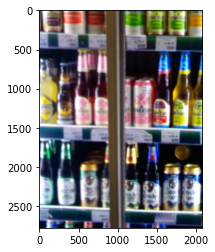

In [ ]:
import math
img=Image.open('/content/drive/MyDrive/train2/positiveimages/oriented_20200921t123717_0b092db6_8fb2_4651_a0ae_86016f997e10.jpg')
frac = 0.60
img.size[0]*frac
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]
cropped_img = img.crop((left, upper, right, bottom))
print(cropped_img.size)
plt.imshow(cropped_img)

In [ ]:
mypath = r'/content/drive/MyDrive/fraudfull/discard/'
directory = r'/content/drive/MyDrive/fraudfull/cropped_discard(0.6)/'
from PIL import Image
import PIL
import cv2
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
print(onlyfiles[0])
print(len(onlyfiles))
for n in range(0, len(onlyfiles)):
  img =Image.open(mypath+onlyfiles[n])
  print("original "+str(n)+"th image size is: "+str(img.size))
  cropped_img = Image.open(directory+onlyfiles[n])
  print("cropped "+str(n)+"th image size is: "+str(cropped_img.size))



In [ ]:
mypath = r'/content/drive/MyDrive/fraudfull/accept/'
directory = r'/content/drive/MyDrive/fraudfull/cropped_accept/'
from PIL import Image
import PIL
import cv2
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
print(onlyfiles[0])
print(len(onlyfiles))
for n in range(0, len(onlyfiles)):
  img=Image.open(mypath + onlyfiles[n])
  filename = directory + onlyfiles[n]
  frac = 0.60
  left = img.size[0]*((1-frac)/2)
  upper = img.size[1]*((1-frac)/2)
  right = img.size[0]-((1-frac)/2)*img.size[0]
  bottom = img.size[1]-((1-frac)/2)*img.size[1]
  cropped_img = img.crop((left, upper, right, bottom))
  cropped_img = cropped_img.save(os.path.join(directory,onlyfiles[n]))
  print(str(n) +"th image saved")


oriented_20220525t112111_34e3f628_b2cb_4382_a2d7_98e671a779a7.jpg
1245
0th image saved
1th image saved
2th image saved
3th image saved
4th image saved
5th image saved
6th image saved
7th image saved
8th image saved
9th image saved
10th image saved
11th image saved
12th image saved
13th image saved
14th image saved
15th image saved
16th image saved
17th image saved
18th image saved
19th image saved
20th image saved
21th image saved
22th image saved
23th image saved
24th image saved
25th image saved
26th image saved
27th image saved
28th image saved
29th image saved
30th image saved
31th image saved
32th image saved
33th image saved
34th image saved
35th image saved
36th image saved
37th image saved
38th image saved
39th image saved
40th image saved
41th image saved
42th image saved
43th image saved
44th image saved
45th image saved
46th image saved
47th image saved
48th image saved
49th image saved
50th image saved
51th image saved
52th image saved
53th image saved
54th image saved
55th

# CropBrightest


In [ ]:
##Takes the brightest part of the image for better moiré detection.

from tkinter import Image
from PIL import Image, ImageStat
import glob
import os
from enum import Enum
import math
import os
from os import listdir


dict_all = {}

def brightness( im_file ): #computes overall brightness value of the given im_file
   im = Image.open(im_file)
   print("nur")
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   res =  math.sqrt(0.299*(r**2) + 0.587*(g**2) + 0.114*(b**2))
   #dict_all[im_file] = res
   return res

directory = '' #To store all cropped images for brightness function to use.
mypath = '' #Images to be cropped.
brightest_image_path ='' #folder to save brightest part of the image.
from PIL import Image
import PIL
import os
from os import listdir
# get the path/directory
brightest_image_list = []
def find_brightest_square():
    for images in os.listdir(mypath):
        brightness_values ={}
        img = Image.open(os.path.join(mypath,images))
        frac = 0.70
        square_dict = {'upper_left':[0,img.size[0]*frac,0,img.size[1]*frac],
                   'upper_right':[img.size[0]-img.size[0]*frac,img.size[0],0,img.size[1]*frac],
                   'bottom_left':[0,img.size[0]*frac,img.size[1]-img.size[1]*frac,img.size[1]],
                   'bottom_right':[img.size[0]-img.size[0]*frac,img.size[0],img.size[1]-img.size[1]*frac,img.size[1]],
                       'center': [img.size[0]*((1-frac)/2),img.size[0]-((1-frac)/2)*img.size[0],img.size[1]*((1-frac)/2),img.size[1]-((1-frac)/2)*img.size[1]]}
        for squares in square_dict:
            coordinates = square_dict.get(squares)
            print(coordinates)
            left = coordinates[0]
            right = coordinates[1]
            upper = coordinates[2]
            bottom = coordinates[3]
            cropped_img = img.crop((left, upper, right, bottom))
            direc = os.path.join(directory,squares+images)
            cropped_img.save(direc)
            res = brightness(direc)
            brightness_values[squares+images] =res
        max_key = max(brightness_values, key=brightness_values.get)
        max_img = Image.open(os.path.join(directory,max_key))
        max_img.save(os.path.join(brightest_image_path,max_key))
find_brightest_square()

